<a href="https://colab.research.google.com/github/AvantiShri/gcp_analysis_rough/blob/main/query%20set%20def%20Copy_of_GCP1_heldout_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/GCP_data/all_data

Mounted at /content/drive
/content/drive/MyDrive/GCP_data/all_data


In [2]:
!pip uninstall -y gcpdatautils
!pip install git+https://github.com/AvantiShri/gcpdatautils.git

  Cloning https://github.com/AvantiShri/gcpdatautils.git to /tmp/pip-req-build-f8x6p1f0
  Running command git clone --filter=blob:none --quiet https://github.com/AvantiShri/gcpdatautils.git /tmp/pip-req-build-f8x6p1f0
  Resolved https://github.com/AvantiShri/gcpdatautils.git to commit 6274642ab27e5539a77b452079749596450731d1
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for gcpdatautils: filename=gcpdatautils-0.1.0.0-py3-none-any.whl size=6118 sha256=2b0bf1e63d7bafd0cbde2faa3dda58eba22818ba28bbfc8ecdfc831f63ae0229
  Stored in directory: /tmp/pip-ephem-wheel-cache-ce4qfzdm/wheels/fe/f9/b7/d5afa50c9e111dcf3a66edb57f0c2273e54d108591664596b8
  Created wheel for bs4: filename=bs4-0.0.1-py3-none-any.whl size=1256 sha256=b19944b2058ba0682a94593c3d0e6efba94d1306b4db671cf38d2395caf4083b
  Stored in directory: /root/.cache/pip/wheels/25/42/45/b773edc52acb16cd2db4cf1a0b47117e2f69bb4eb300ed0e70
Successfully built gcpdatautils bs4


In [3]:
!mkdir analysis

mkdir: cannot create directory ‘analysis’: File exists


In [ ]:
import numpy as np
from collections import defaultdict
import h5py
from datetime import datetime, timedelta
from gcpdatautils import GCPMissingDataError, ROTTEN_EGGS, parse_rotten_egg_file

class GCPHdf5DataReader(object):

  def __init__(self, bad_data_file=ROTTEN_EGGS,
                     year_to_hdf5path=lambda x: "GCP1data_"+str(x)+".hdf5"):
    print("Parsing the bad data file:",bad_data_file)
    #reorganize the bad data list by device ID
    self.bad_data_lookup = defaultdict(list)
    for baddata_starttime, baddata_endtime, deviceid in parse_rotten_egg_file(bad_data_file):
      self.bad_data_lookup[deviceid].append((baddata_starttime, baddata_endtime))
    self.year_to_hdf5fh = {} #mapping from the year to the hdf5 file handle
    self.year_to_hdf5path = year_to_hdf5path

  def fetch_data(self, starttime, endtime, normalize=False):

    if (endtime.strftime("%Y-%m-%d") == starttime.strftime("%Y-%m-%d")):
      return self.fetch_data_within_day_normalize(starttime, endtime, normalize=normalize) #returns both data and devices
    else:
      #split into accesses over multiple days
      start_day = starttime.strftime("%Y-%m-%d")
      end_day = endtime.strftime("%Y-%m-%d")
      #for the first day:
      day_accesses = [ (
          starttime,
          datetime.strptime(start_day+" 23:59:59", '%Y-%m-%d %H:%M:%S')) ]
      #for intermediate days:
      dayoffset = 1
      inter_day = (starttime + timedelta(days=dayoffset)).strftime("%Y-%m-%d")
      while inter_day != end_day:
        day_accesses.append(
            (datetime.strptime(inter_day+" 00:00:00", '%Y-%m-%d %H:%M:%S'),
             datetime.strptime(inter_day+" 23:59:59", '%Y-%m-%d %H:%M:%S')))
        dayoffset += 1
        inter_day = (starttime + timedelta(days=dayoffset)).strftime("%Y-%m-%d")

      #for the final day
      day_accesses.append(
          (datetime.strptime(inter_day+" 00:00:00", '%Y-%m-%d %H:%M:%S'),
           endtime))
      days_data_and_devices = [self.fetch_data_within_day_normalize(t1, t2, normalize=normalize) for (t1,t2) in day_accesses]
      #if all the days have the same sets of devices...
      if (len(set([str(x[1]) for x in days_data_and_devices]))==1):
        return np.concatenate([x[0] for x in days_data_and_devices], axis=0), days_data_and_devices[0][1]
      else:
        #print("Some days don't have same devices. Rearranging")
        all_devices = set()
        [all_devices.update(x[1]) for x in days_data_and_devices]
        all_devices = sorted(all_devices)
        all_devices_newidxs = dict([(x[1],x[0]) for x in enumerate(all_devices)])
        rearranged_days_data = []
        for day_data, day_devices in days_data_and_devices:
          rearranged_day_data = np.zeros((len(day_data), len(all_devices)))
          rearranged_day_data[:,:] = np.nan
          for orig_deviceidx, deviceid in enumerate(day_devices):
            rearranged_day_data[:,all_devices_newidxs[deviceid]] = day_data[:,orig_deviceidx]
          rearranged_days_data.append(rearranged_day_data)
        return np.concatenate(rearranged_days_data, axis=0), all_devices

  def fetch_data_within_day_normalize(self, starttime, endtime, normalize):
    if (normalize==False):
      return self.fetch_data_within_day(starttime, endtime)
    else:
      day = starttime.strftime("%Y-%m-%d")
      day_start = datetime.strptime(day+" 00:00:00", '%Y-%m-%d %H:%M:%S')
      day_end = datetime.strptime(day+" 23:59:59", '%Y-%m-%d %H:%M:%S')
      full_day_data, daydevices = self.fetch_data_within_day(day_start, day_end)
      #set ddof=1 to get unbiased (more conservative) stdev estimates
      device_day_stdevs = np.nan_to_num(np.nanstd(full_day_data, axis=0, ddof=1), np.sqrt(50))
      device_day_means = np.nan_to_num(np.nanmean(full_day_data, axis=0), 100)
      #transform the data to be centered around 100, with stdev of sqrt(50)
      full_day_data_normalized = ((full_day_data - device_day_means[None,:])/
                                  (device_day_stdevs[None,:]/np.sqrt(50))) + 100
      start_offset =  int(starttime.timestamp() - day_start.timestamp())
      end_offset = int((endtime.timestamp() - day_start.timestamp()) + 1)
      return full_day_data_normalized[start_offset:end_offset], daydevices

  def get_fh_for_year(self, year):
    if (year not in self.year_to_hdf5fh):
      self.year_to_hdf5fh[year] = h5py.File(self.year_to_hdf5path(year), "r")
    return self.year_to_hdf5fh[year]

  def get_available_days_in_year(self, year):
    fh = self.get_fh_for_year(year)
    return fh.keys()

  def fetch_data_within_day(self, starttime, endtime):
    assert endtime.strftime("%Y-%m-%d") == starttime.strftime("%Y-%m-%d")
    year = starttime.year
    fh = self.get_fh_for_year(year)
    day = starttime.strftime("%Y-%m-%d")
    if (day not in fh):
      raise GCPMissingDataError("data for "+day+" not present")
    dset = fh[day]
    if dset.attrs['start_time'] > starttime.timestamp():
      raise GCPMissingDataError("query for day "
             +day+" starts at "+str(starttime.timestamp())
             +" but data for day starts at "+str(dset.attrs['start_time']))
    if dset.attrs['end_time'] < endtime.timestamp():
      raise GCPMissingDataError("query for day "
             +day+" ends at "+str(endtime.timestamp())
             +" but data for day ends at "+str(dset.attrs['end_time']))
    #now that we have verified that the day has all the data we need...
    start_offset = int(starttime.timestamp() - dset.attrs['start_time'])
    end_offset = int(endtime.timestamp()+1 - dset.attrs['start_time']) #add +1 since GCP ranges are end-inclusive
    day_data = np.array(dset[start_offset:end_offset]).astype("float")
    #replace 255 with nan
    day_data[day_data==255] = np.nan
    #Radin 2023 (Anomalous entropic effects in physical systems associated
    # with collective consciousness) said "All individual samples within a matrix
    # less than 55 or greater than 145 were set to nan" so we do that here
    day_data = np.where((day_data < 55), np.nan, day_data)
    day_data = np.where((day_data > 145), np.nan, day_data)

    #Mask out columns with bad data
    masking_occurred = False
    devices_on_day = fh[day].attrs["device_ids"]
    for deviceid_idx,deviceid in enumerate(devices_on_day):
      if (deviceid in self.bad_data_lookup):
        for rottenegg_start, rottenegg_end in self.bad_data_lookup[deviceid]:
          if (rottenegg_start.timestamp() <= endtime.timestamp() and rottenegg_end.timestamp() >= starttime.timestamp()):
            if (masking_occurred == False):
              print("Before masking, fraction of nans in raw data is", np.mean(np.isnan(day_data)),"for",starttime,"to",endtime)
            masking_occurred = True
            print("Found 'rotten egg' entries for device id:",deviceid,
                  "in time range",starttime,"to",endtime,
                  "(range:",rottenegg_start,"to",rottenegg_end,")")
            mask_startidx = int(max(rottenegg_start.timestamp()-starttime.timestamp(),0))
            mask_endidx = int(min((rottenegg_end.timestamp()+1)-starttime.timestamp(), len(day_data))) #+1 because end inclusive
            day_data[mask_startidx:mask_endidx, deviceid_idx] = np.nan

    if (masking_occurred):
      print("After masking, fraction of nans in raw data is", np.mean(np.isnan(day_data)))
    #Check that there are no rows that completely lack data
    nonnan_devices_per_second = np.sum(np.isnan(day_data)==False, axis=1)
    if (np.min(nonnan_devices_per_second)==0):
      raise GCPMissingDataError("Some seconds for query from "+str(starttime)+" to "+str(endtime)+" had no data")

    return day_data, devices_on_day

  def __exit__(self, exc_type, exc_value, traceback):
    self.close()

  def close(self):
    for fh in self.year_to_hdf5fh.values():
      fh.close()

gcp_data_reader = GCPHdf5DataReader()

Parsing the bad data file: /usr/local/lib/python3.10/dist-packages/gcpdatautils/resources/rotteneggs.txt
manually correcting 47,2000-01-01 00:00:00,2001-06-31 23:59:59,2222
manually correcting 47,2008-04-25 00:00:00,2008-04-55 23:59:59,1092


In [ ]:
#for a given year
#iterate through days in the year
#for each day
#read in the *normalized* data
#do the splits
#compute the stats for non-overlapping 1 min blocks
#append to a new array with start & end info

import h5py
from datetime import datetime, timedelta
import numpy as np
import scipy

def compute_composite_zscores(data):
  composite_zs = np.nansum((data-100)/np.sqrt(50),axis=1)/np.sqrt(
        np.sum(np.isnan(data)==False, axis=1))
  return composite_zs

def compute_zscore_for_chisquared_test(data):
  return scipy.stats.norm.ppf(scipy.stats.chi2.cdf(
            np.sum(np.square(
                compute_composite_zscores(data))), len(data)))

def indices_to_binaryflagrep(indices):
  result = 0
  for idx in indices:
    result += 1 << idx
  return result

MINDEVICES = 10
SEED = 1234
SPANLENGTH = 60 #specify span in seconds
QUERY_THRESHOLD = 1 #if query score is above this, heldout scores will be retained for analysis

assert (24*60*60)%SPANLENGTH == 0 #assert span divides day

cumulative_heldout_z_passing_threshold = 0
n_for_stouffers_z = 0

for year in range(1998,2023):
#for year in range(2007,2023):

  rng = np.random.RandomState(SEED)

  all_query_stats_chisqtoz = []
  all_heldout_stats_chisqtoz = []
  span_start_timestamps = []
  query_deviceflags = []
  heldout_deviceflags = []

  available_days = gcp_data_reader.get_available_days_in_year(year)

  for day in available_days:
    print("On day",day)
    day_start = datetime.strptime(day+" 00:00:00", '%Y-%m-%d %H:%M:%S')
    day_end = datetime.strptime(day+" 23:59:59", '%Y-%m-%d %H:%M:%S')
    try:
      full_day_data, day_devices = gcp_data_reader.fetch_data_within_day_normalize(
          day_start, day_end, normalize=True)
      if (len(full_day_data) < 60*60*24):
        continue #skip incomplete days
      else:
        for span_idx in range(int(60*60*24/SPANLENGTH)):
          span_data = full_day_data[span_idx*SPANLENGTH : (span_idx+1)*SPANLENGTH]
          nanfrac = np.mean(np.isnan(span_data),axis=0)
          deviceindices_with_full_data = np.arange(len(day_devices))[nanfrac==0.0]
          #Only do the split when there's a reasonably large num of non-nan devices for the span
          if (len(deviceindices_with_full_data) >= MINDEVICES):
            #do a random permutation of device indices
            shuffled_device_indices = rng.permutation(deviceindices_with_full_data)
            #take the first half (rounding up) as the 'query' and the other have as eval
            num_in_query_set = int(np.ceil(len(shuffled_device_indices)/2.0))
            query_device_indices = shuffled_device_indices[:num_in_query_set]
            heldout_device_indices = shuffled_device_indices[num_in_query_set:]
            query_data = span_data[:, query_device_indices]
            heldout_data = span_data[:, heldout_device_indices]
            query_stats_chisqtoz = compute_zscore_for_chisquared_test(query_data)
            heldout_data_chisqtoz = compute_zscore_for_chisquared_test(heldout_data)
            query_devices_flagrep = indices_to_binaryflagrep(query_device_indices)
            heldout_devices_flagrep = indices_to_binaryflagrep(heldout_device_indices)
            all_devices_flagrep = indices_to_binaryflagrep(deviceindices_with_full_data)
            assert (query_devices_flagrep & heldout_devices_flagrep) == 0
            assert (query_devices_flagrep | heldout_devices_flagrep) == all_devices_flagrep
            #store the stats
            span_start_timestamp = (day_start + timedelta(seconds=span_idx*SPANLENGTH)).timestamp()
            all_query_stats_chisqtoz.append(query_stats_chisqtoz)
            all_heldout_stats_chisqtoz.append(heldout_data_chisqtoz)
            span_start_timestamps.append(span_start_timestamp)
            query_deviceflags.append(query_devices_flagrep)
            heldout_deviceflags.append(heldout_devices_flagrep)
            if (query_stats_chisqtoz > QUERY_THRESHOLD):
              cumulative_heldout_z_passing_threshold += heldout_data_chisqtoz
              n_for_stouffers_z += 1
    except GCPMissingDataError as e:
      print("MISSING DATA ERROR!",e)
    if (n_for_stouffers_z > 0):
      print("Heldout Stouffer's Z (n="+str(n_for_stouffers_z)+")",
          cumulative_heldout_z_passing_threshold/np.sqrt(n_for_stouffers_z))

  #save the results for the year
  np.save("analysis/"+str(year)+"_"+str(SPANLENGTH)+"_all_query_stats_chisqtoz.npy",
          np.array(all_query_stats_chisqtoz))
  np.save("analysis/"+str(year)+"_"+str(SPANLENGTH)+"_all_heldout_stats_chisqtoz.npy",
          np.array(all_heldout_stats_chisqtoz))
  np.save("analysis/"+str(year)+"_"+str(SPANLENGTH)+"_span_start_timestamps.npy",
          np.array(span_start_timestamps))
  np.save("analysis/"+str(year)+"_"+str(SPANLENGTH)+"_query_deviceflags.npy",
          np.array(query_deviceflags))
  np.save("analysis/"+str(year)+"_"+str(SPANLENGTH)+"_heldout_deviceflags.npy",
          np.array(heldout_deviceflags))

On day 1998-08-05
On day 1998-08-06
On day 1998-08-07
On day 1998-08-08
On day 1998-08-09
On day 1998-08-10
On day 1998-08-11
On day 1998-08-12
On day 1998-08-13
On day 1998-08-14
MISSING DATA ERROR! query for day 1998-08-14 starts at 903052800.0 but data for day starts at 903052830
On day 1998-08-15
MISSING DATA ERROR! Some seconds for query from 1998-08-15 00:00:00 to 1998-08-15 23:59:59 had no data
On day 1998-08-16
MISSING DATA ERROR! Some seconds for query from 1998-08-16 00:00:00 to 1998-08-16 23:59:59 had no data
On day 1998-08-17
MISSING DATA ERROR! Some seconds for query from 1998-08-17 00:00:00 to 1998-08-17 23:59:59 had no data
On day 1998-08-18
MISSING DATA ERROR! Some seconds for query from 1998-08-18 00:00:00 to 1998-08-18 23:59:59 had no data
On day 1998-08-19
MISSING DATA ERROR! Some seconds for query from 1998-08-19 00:00:00 to 1998-08-19 23:59:59 had no data
On day 1998-08-20
On day 1998-08-21
On day 1998-08-22
On day 1998-08-23
MISSING DATA ERROR! Some seconds for qu

<ipython-input-7-067d6b8ab326>:74: RuntimeWarning: Mean of empty slice
  device_day_means = np.nan_to_num(np.nanmean(full_day_data, axis=0), 100)


On day 1998-11-15
On day 1998-11-16
On day 1998-11-17
On day 1998-11-18
On day 1998-11-19
On day 1998-11-20
On day 1998-11-21
On day 1998-11-22
On day 1998-11-23
On day 1998-11-24
On day 1998-11-25
On day 1998-11-26
On day 1998-11-27
On day 1998-11-28
On day 1998-11-29
On day 1998-11-30
On day 1998-12-01
On day 1998-12-02
On day 1998-12-03
On day 1998-12-04
On day 1998-12-05
On day 1998-12-06
On day 1998-12-07
On day 1998-12-08
On day 1998-12-09
On day 1998-12-10
Before masking, fraction of nans in raw data is 0.15488095238095237 for 1998-12-10 00:00:00 to 1998-12-10 23:59:59
Found 'rotten egg' entries for device id: 1005 in time range 1998-12-10 00:00:00 to 1998-12-10 23:59:59 (range: 1998-12-10 00:00:00 to 1998-12-17 23:59:59 )
After masking, fraction of nans in raw data is 0.15585482804232803
On day 1998-12-11
Before masking, fraction of nans in raw data is 4.96031746031746e-06 for 1998-12-11 00:00:00 to 1998-12-11 23:59:59
Found 'rotten egg' entries for device id: 1005 in time rang

<ipython-input-7-067d6b8ab326>:76: RuntimeWarning: invalid value encountered in divide
  full_day_data_normalized = ((full_day_data - device_day_means[None,:])/


Streaming output truncated to the last 5000 lines.
On day 2011-10-22
Heldout Stouffer's Z (n=1056326) 0.8436987948803881
On day 2011-10-23
Heldout Stouffer's Z (n=1056567) 0.8481869459746307
On day 2011-10-24
Heldout Stouffer's Z (n=1056783) 0.836863708892343
On day 2011-10-25
Heldout Stouffer's Z (n=1056996) 0.8511711782427226
On day 2011-10-26
Heldout Stouffer's Z (n=1057211) 0.8565392558203344
On day 2011-10-27
Heldout Stouffer's Z (n=1057424) 0.8634355588986407
On day 2011-10-28
Heldout Stouffer's Z (n=1057639) 0.8656674599437585
On day 2011-10-29
Heldout Stouffer's Z (n=1057834) 0.8906577367485624
On day 2011-10-30
Heldout Stouffer's Z (n=1058074) 0.8822201218765373
On day 2011-10-31
Heldout Stouffer's Z (n=1058329) 0.8753080247335837
On day 2011-11-01
Heldout Stouffer's Z (n=1058570) 0.8736160202213912
On day 2011-11-02
Heldout Stouffer's Z (n=1058782) 0.8785971287989222
On day 2011-11-03
Heldout Stouffer's Z (n=1059001) 0.8824075988763211
On day 2011-11-04
Heldout Stouffer's Z (

Sanity check for each year

In [22]:
def load_data(year, spanlength):
  all_query_stats_chisqtoz = np.load("analysis/"+str(year)+"_"+str(spanlength)+"_all_query_stats_chisqtoz.npy")
  all_heldout_stats_chisqtoz = np.load("analysis/"+str(year)+"_"+str(spanlength)+"_all_heldout_stats_chisqtoz.npy")
  span_start_timestamps = np.load("analysis/"+str(year)+"_"+str(spanlength)+"_span_start_timestamps.npy")
  query_deviceflags = np.load("analysis/"+str(year)+"_"+str(spanlength)+"_query_deviceflags.npy")
  heldout_deviceflags = np.load("analysis/"+str(year)+"_"+str(spanlength)+"_heldout_deviceflags.npy")

  return (all_query_stats_chisqtoz,
          all_heldout_stats_chisqtoz,
          span_start_timestamps,
          query_deviceflags, heldout_deviceflags)


def define_events(query_stats, sliding_window_length, min_score):
  #get the event significance for sliding windows of size sliding_window_length
  cumsum_query_stats = np.pad(np.cumsum(query_stats), [(1,0)]) #also pad with a zero at the start
  sliding_window_query_stats = (cumsum_query_stats[sliding_window_length:] - cumsum_query_stats[:-sliding_window_length])/np.sqrt(sliding_window_length)
  argsort_sliding_window_query_stats = np.argsort(-sliding_window_query_stats) #sort in desc order
  masked_window_starts = np.zeros_like(sliding_window_query_stats) #used to track included windows
  events_start_end_idxs = []
  #march down the argsort list until dip below minscore
  for sliding_window_idx in argsort_sliding_window_query_stats:
    if (masked_window_starts[sliding_window_idx]==0): #this window does not overlap with a previously-included window
      if (sliding_window_query_stats[sliding_window_idx] >= min_score):
        events_start_end_idxs.append((sliding_window_idx, sliding_window_idx+sliding_window_length))
        #mask out the start idx positions of all overlapping windows
        masked_window_starts[max(sliding_window_idx-(sliding_window_length-1),0):
                             (sliding_window_idx+sliding_window_length)] = 1
      else:
        break
  #do a sanity check on all the event start & ends to ensure non-overlapping and
  # defined appropriately
  event_def_sanity_check = np.zeros_like(query_stats)
  for (event_start_idx, event_end_idx) in events_start_end_idxs:
    #print(event_start_idx, event_end_idx)
    assert np.sum(query_stats[event_start_idx:event_end_idx])/np.sqrt(sliding_window_length) >= min_score
    assert np.sum(event_def_sanity_check[event_start_idx:event_end_idx]) == 0 #assert non-overlapping
    event_def_sanity_check[event_start_idx:event_end_idx] = 1
    assert np.sum(event_def_sanity_check[event_start_idx:event_end_idx]) == sliding_window_length
  return events_start_end_idxs


Analysis for year 1999
NormaltestResult(statistic=0.09843771268634055, pvalue=0.9519727616205927)
NormaltestResult(statistic=0.43799539804249565, pvalue=0.8033235665819578)
73591


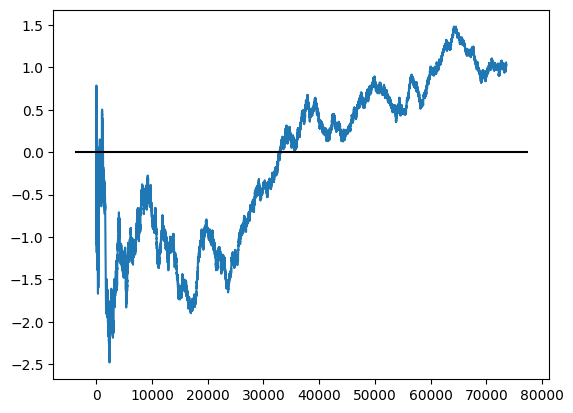

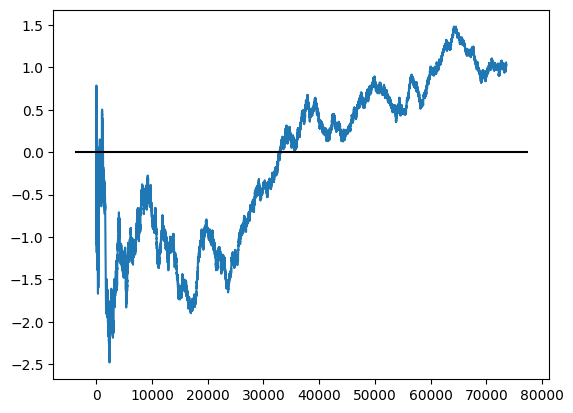

Analysis for year 2000
NormaltestResult(statistic=1.4317580507811303, pvalue=0.4887622884496925)
NormaltestResult(statistic=4.071380038921698, pvalue=0.1305903415310335)
83899


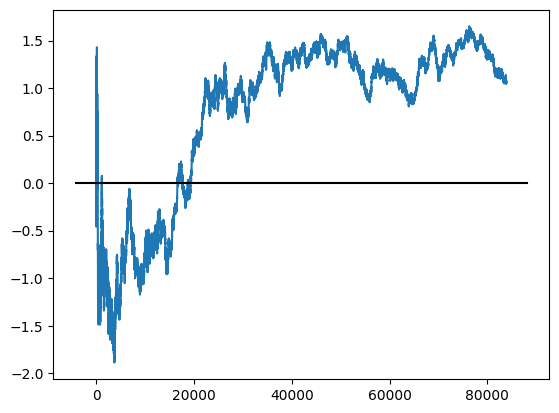

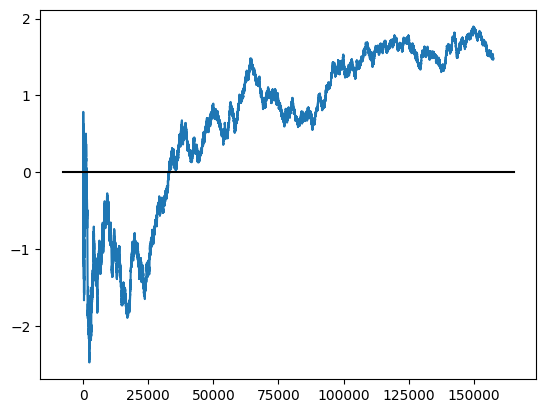

Analysis for year 2001
NormaltestResult(statistic=1.4623726391780651, pvalue=0.4813376309893833)
NormaltestResult(statistic=2.211948071851152, pvalue=0.3308884280102325)
83586


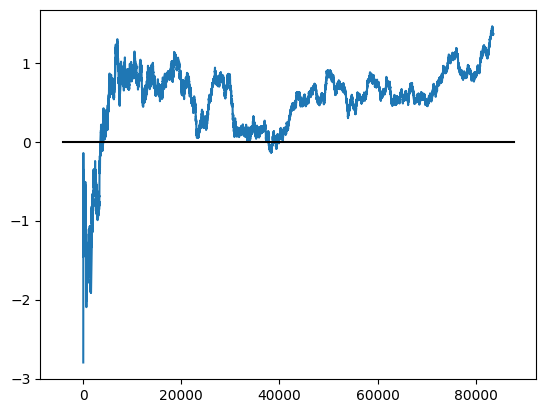

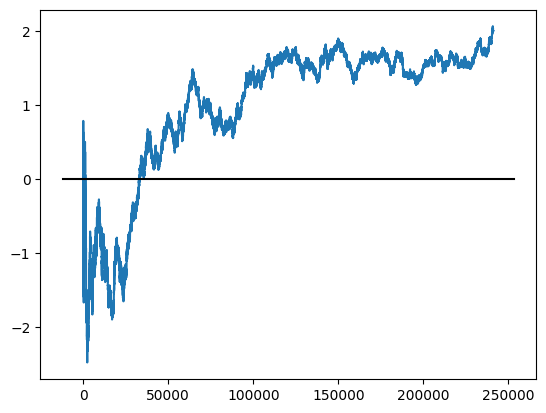

Analysis for year 2002
NormaltestResult(statistic=0.45753503377518856, pvalue=0.7955134554527303)
NormaltestResult(statistic=0.2385131911108434, pvalue=0.8875800224509067)
82152


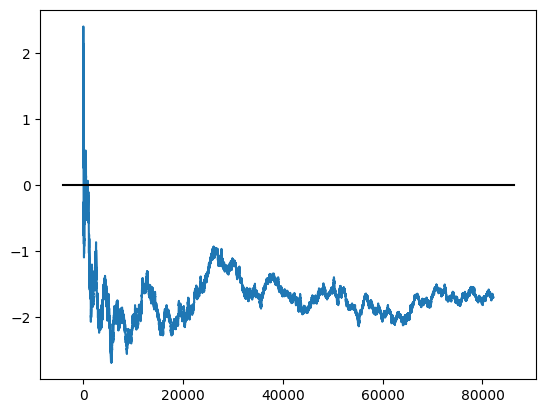

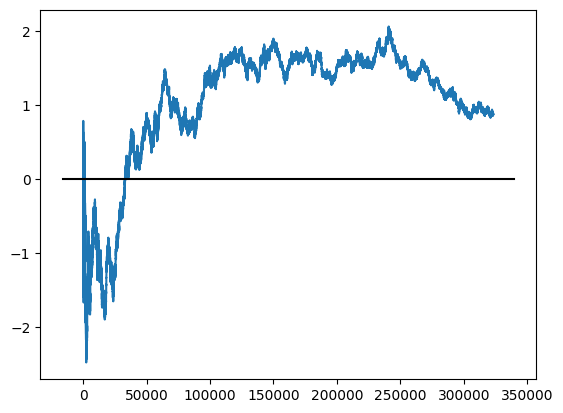

Analysis for year 2003
NormaltestResult(statistic=1.459274630287939, pvalue=0.48208380288195285)
NormaltestResult(statistic=0.13078191296909403, pvalue=0.9367011823807688)
83186


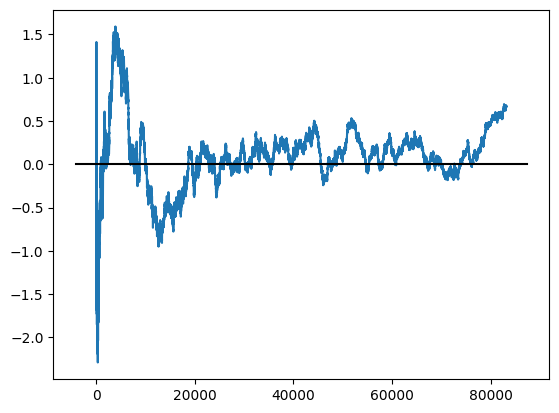

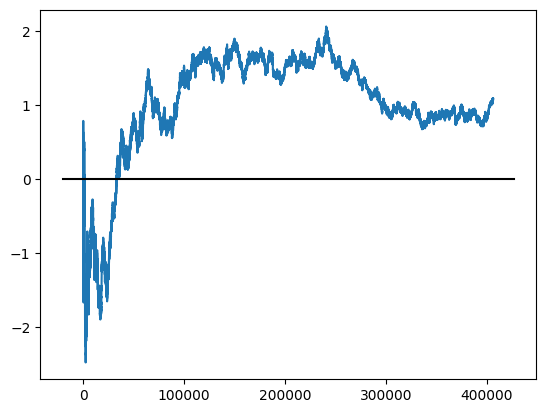

Analysis for year 2004
NormaltestResult(statistic=4.9945242530031955, pvalue=0.08231004489978692)
NormaltestResult(statistic=2.8652997899857864, pvalue=0.2386756181941466)
83916


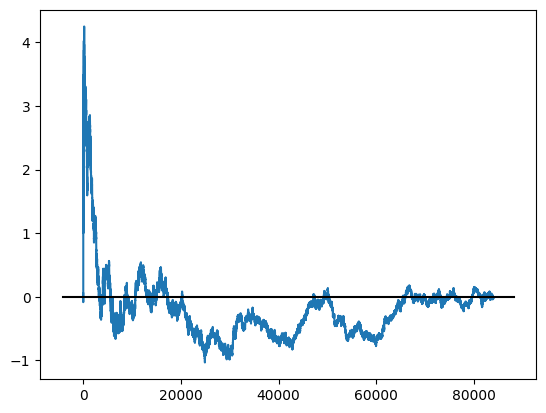

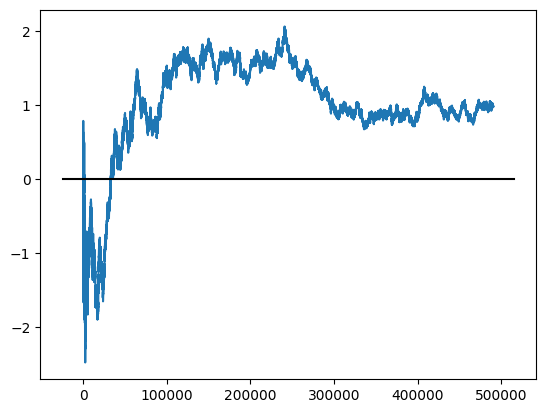

Analysis for year 2005
NormaltestResult(statistic=0.6257077046187802, pvalue=0.7313567908646804)
NormaltestResult(statistic=0.7030625430075277, pvalue=0.7036098466799932)
82915


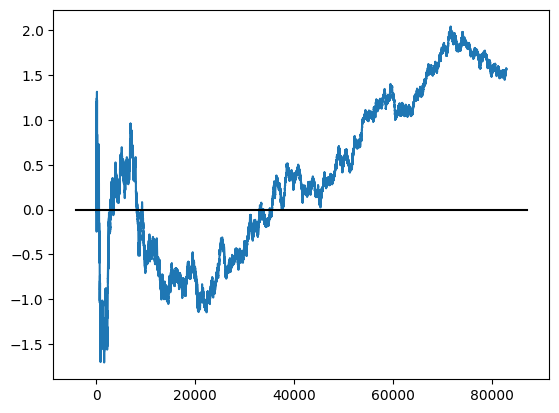

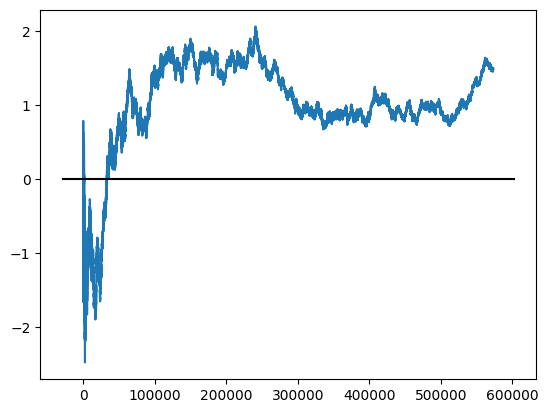

Analysis for year 2006
NormaltestResult(statistic=6.593469727486346, pvalue=0.03700379279038748)
NormaltestResult(statistic=2.1825471106248857, pvalue=0.33578857595134576)
83610


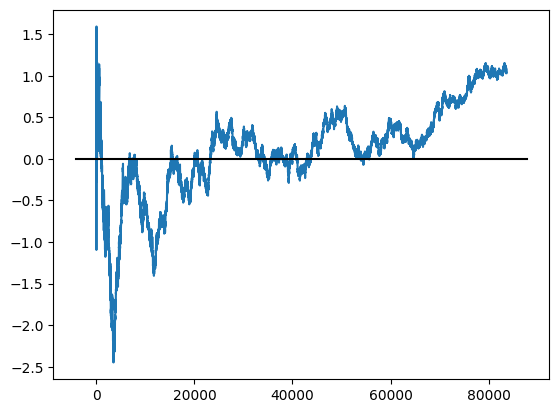

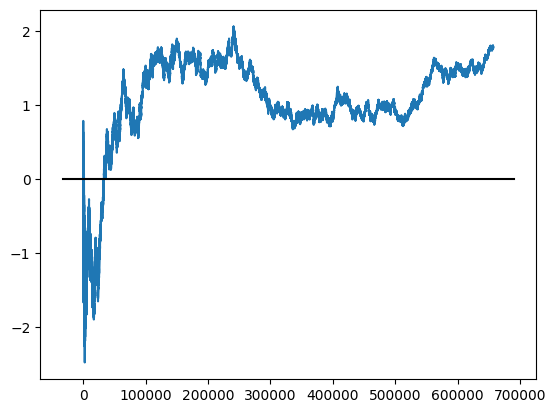

Analysis for year 2007
NormaltestResult(statistic=0.22649797627326634, pvalue=0.8929283038806016)
NormaltestResult(statistic=2.1761558615867163, pvalue=0.33686334652485184)
83197


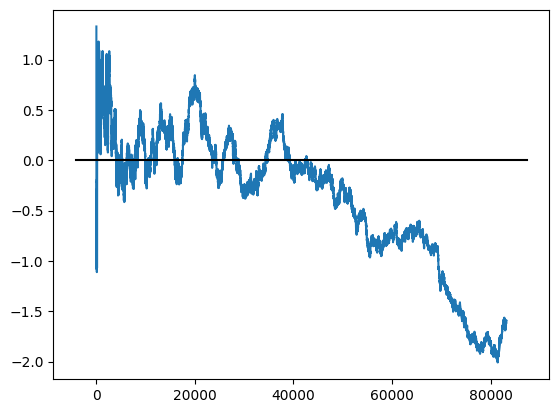

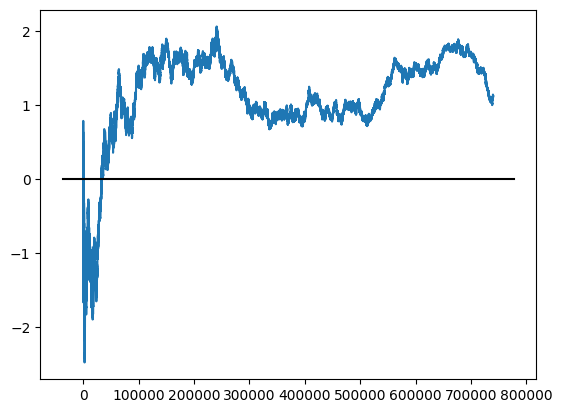

Analysis for year 2008
NormaltestResult(statistic=0.2707480328645144, pvalue=0.8733891886836335)
NormaltestResult(statistic=5.633127869390139, pvalue=0.05981110489412774)
83239


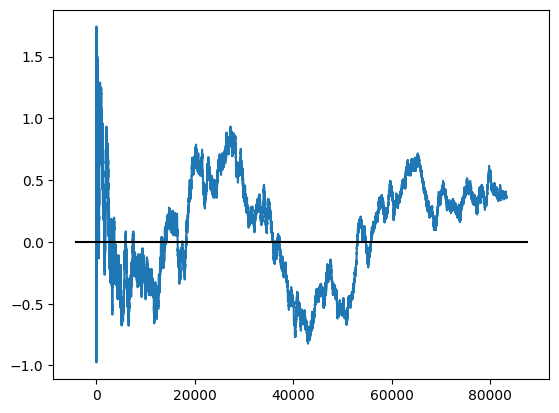

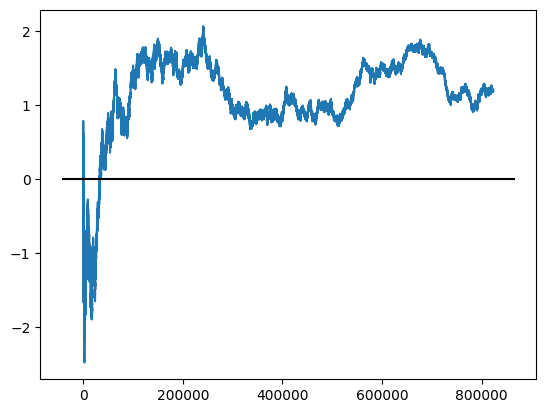

Analysis for year 2009
NormaltestResult(statistic=1.1588053880845213, pvalue=0.5602328970940731)
NormaltestResult(statistic=1.4439395455415382, pvalue=0.48579440830089426)
83728


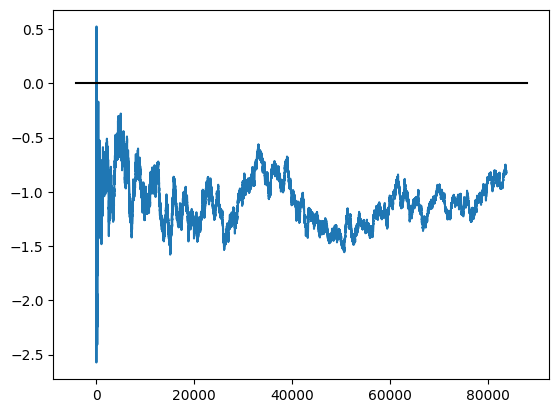

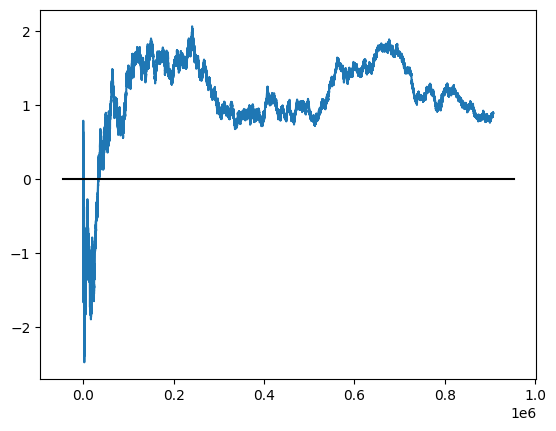

Analysis for year 2010
NormaltestResult(statistic=0.5617924908887991, pvalue=0.7551066771737049)
NormaltestResult(statistic=1.0819944941817057, pvalue=0.5821673980503907)
82917


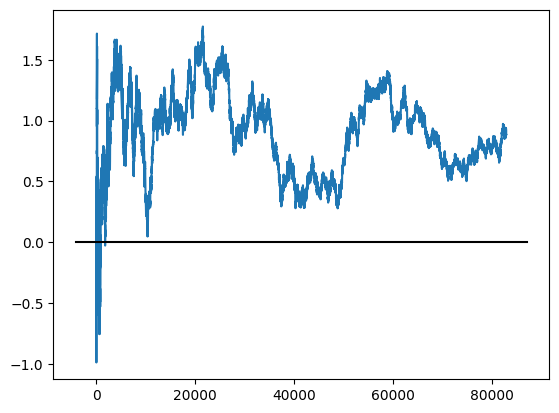

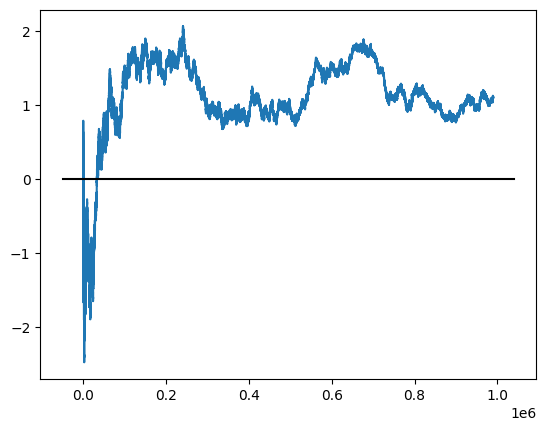

Analysis for year 2011
NormaltestResult(statistic=1.2996275013250609, pvalue=0.5221430164962038)
NormaltestResult(statistic=2.8290389543512564, pvalue=0.2430423728011493)
82185


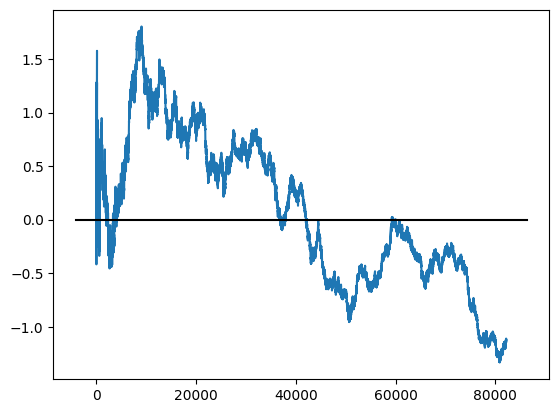

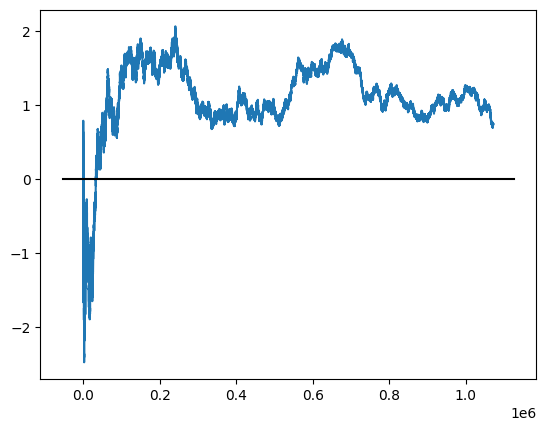

Analysis for year 2012
NormaltestResult(statistic=8.497918103134316, pvalue=0.014279089971788695)
NormaltestResult(statistic=4.856877269270127, pvalue=0.08817439761029337)
83518


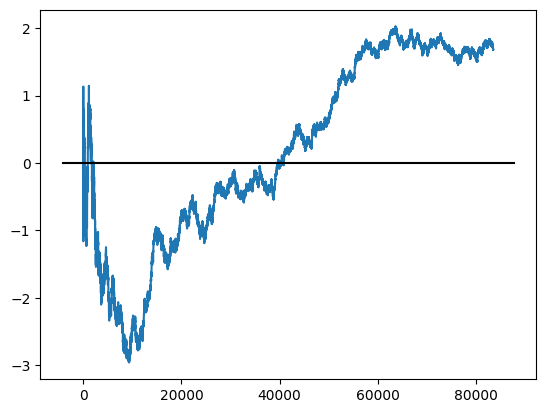

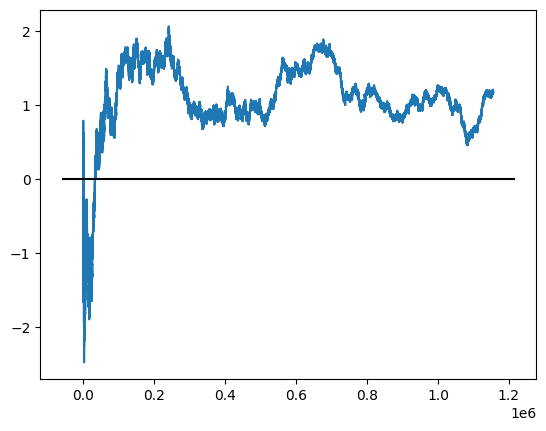

Analysis for year 2013
NormaltestResult(statistic=3.3186720418785773, pvalue=0.19026527032532523)
NormaltestResult(statistic=7.441812068092806, pvalue=0.024212020989544274)
83181


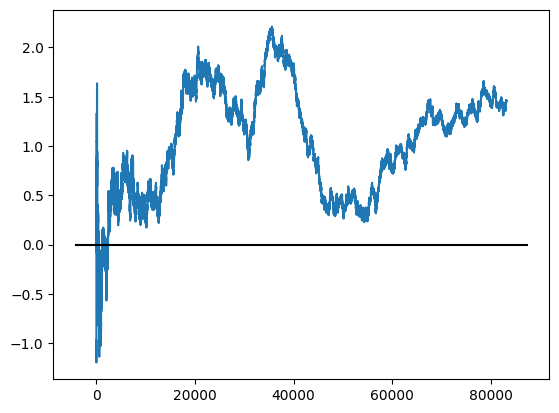

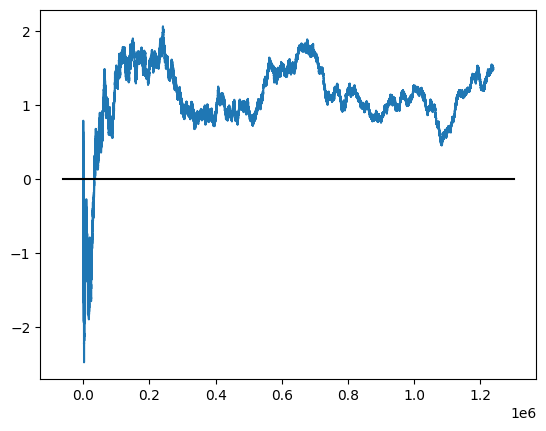

Analysis for year 2014
NormaltestResult(statistic=1.641808788594493, pvalue=0.44003351069597074)
NormaltestResult(statistic=2.3551243567477265, pvalue=0.30802874317258894)
83134


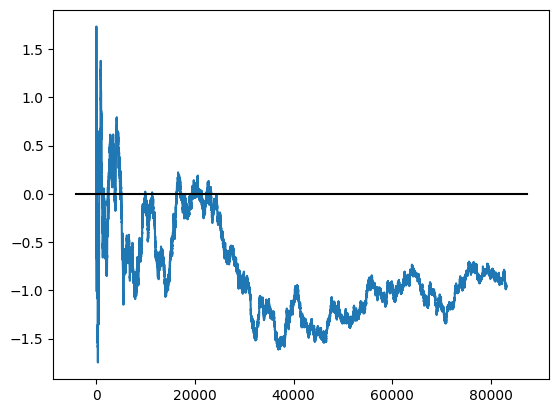

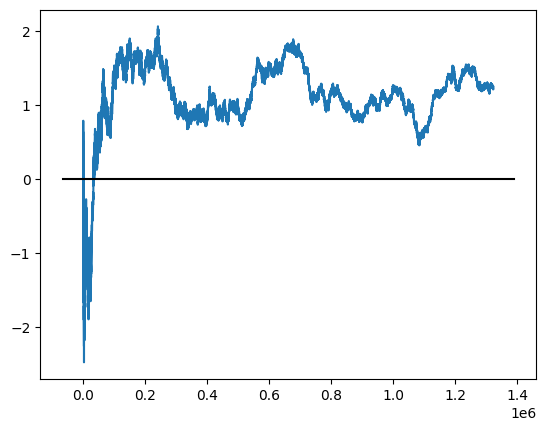

Analysis for year 2015
NormaltestResult(statistic=0.7068758310333388, pvalue=0.702269591279385)
NormaltestResult(statistic=2.1132516566380253, pvalue=0.3476267861397284)
82370


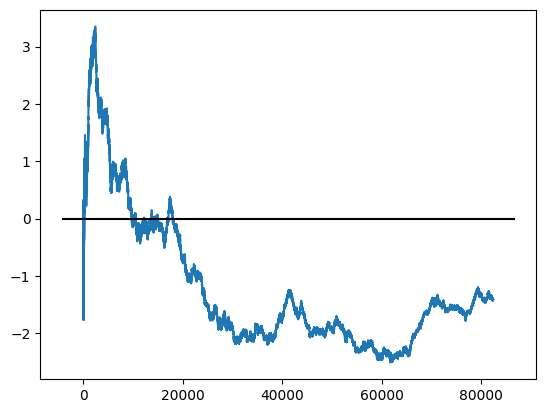

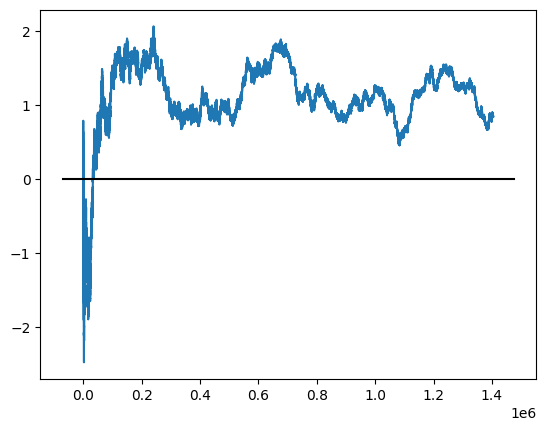

Analysis for year 2016
NormaltestResult(statistic=0.5443630970373848, pvalue=0.761715960131824)
NormaltestResult(statistic=2.611408913900041, pvalue=0.27098157293882125)
82528


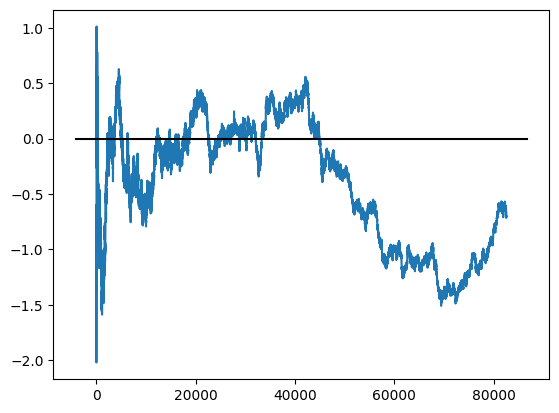

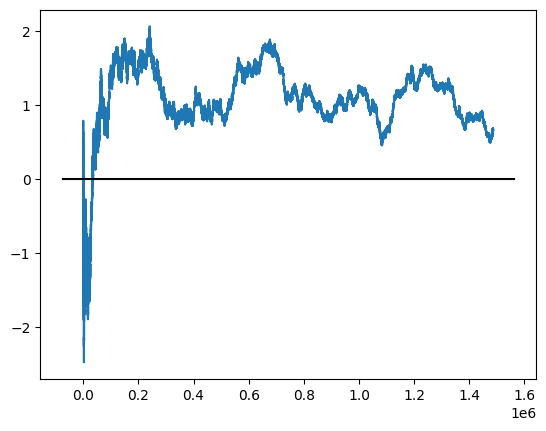

Analysis for year 2017
NormaltestResult(statistic=69.22796685295685, pvalue=9.275514340212473e-16)
NormaltestResult(statistic=58.31329987701607, pvalue=2.1748425484751086e-13)
82735


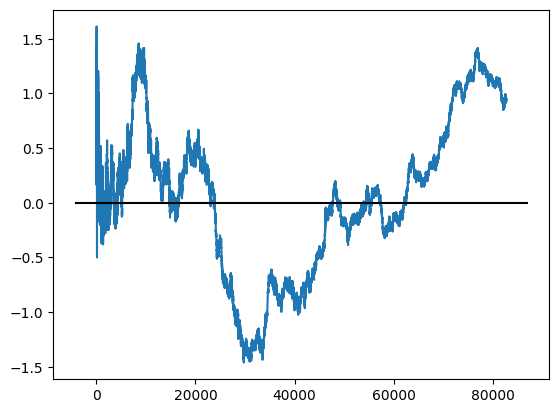

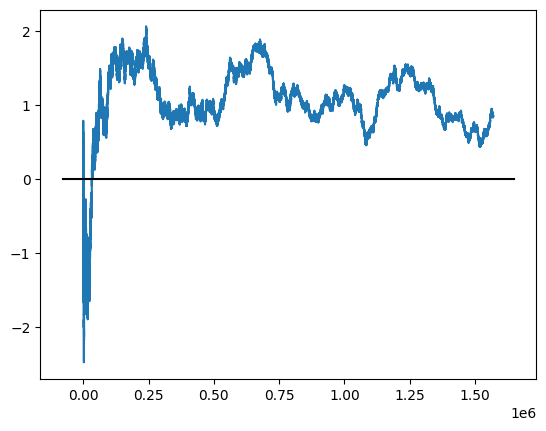

Analysis for year 2018
NormaltestResult(statistic=3.205662739878761, pvalue=0.20132568276694085)
NormaltestResult(statistic=0.2408441285439441, pvalue=0.8865461782748516)
75917


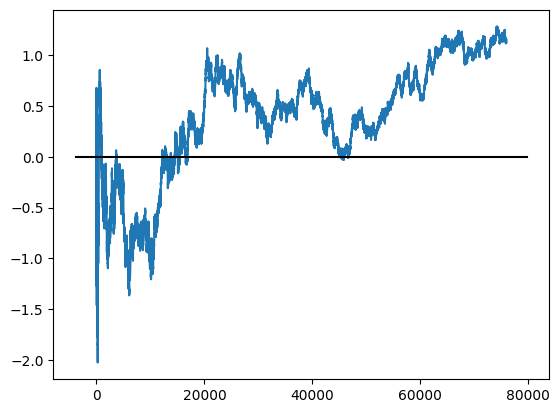

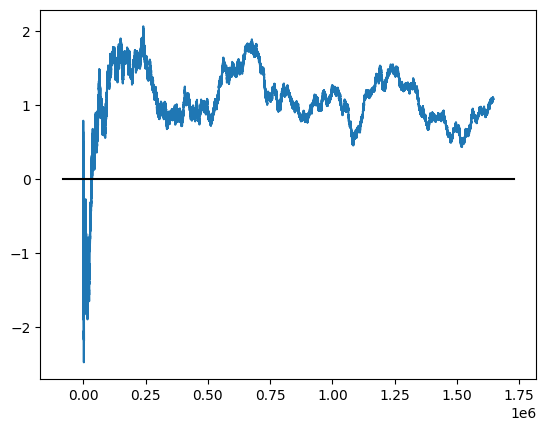

Analysis for year 2019
NormaltestResult(statistic=1.5984658734373594, pvalue=0.44967376009008886)
NormaltestResult(statistic=0.11964625063677221, pvalue=0.9419311226185386)
82638


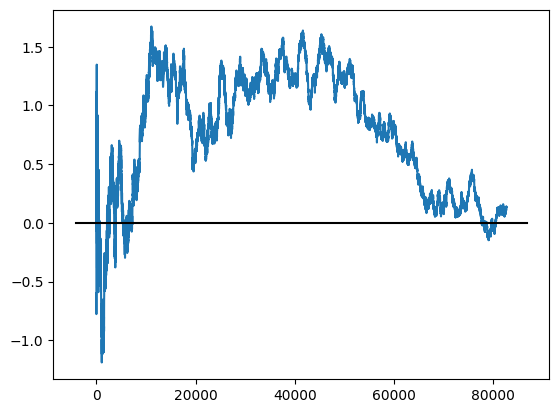

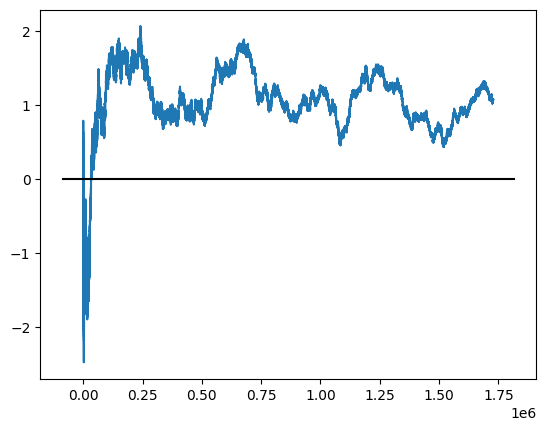

Analysis for year 2020
NormaltestResult(statistic=6.037197240921223, pvalue=0.048869655332807925)
NormaltestResult(statistic=2.552823213777715, pvalue=0.2790367998125793)
82841


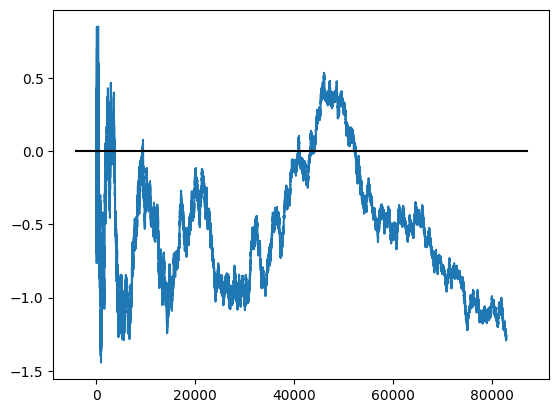

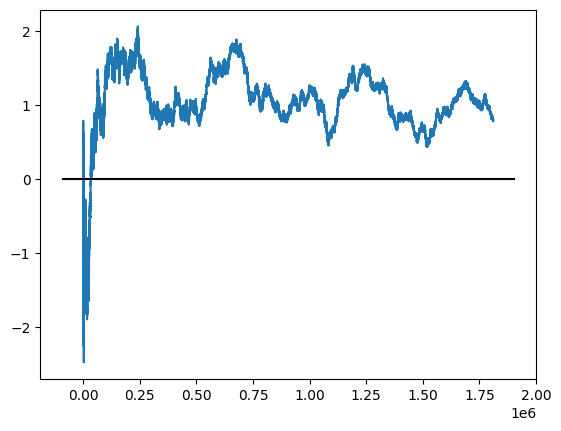

Analysis for year 2021
NormaltestResult(statistic=0.22421214534889763, pvalue=0.893949428864341)
NormaltestResult(statistic=7.245884863970363, pvalue=0.02670398611599254)
82507


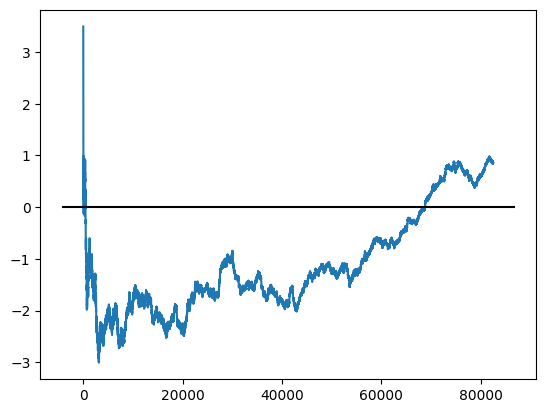

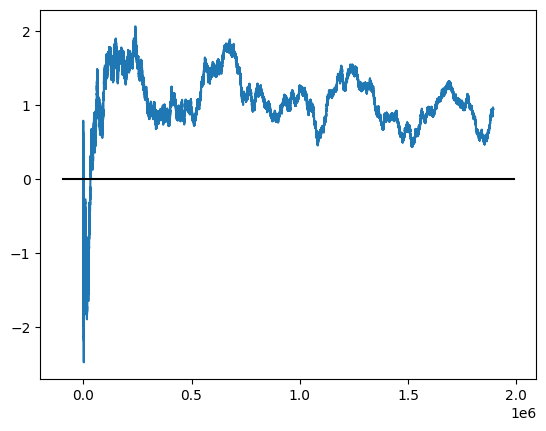

Analysis for year 2022
NormaltestResult(statistic=0.5909617803944544, pvalue=0.7441736355986412)
NormaltestResult(statistic=8.759419975857128, pvalue=0.012528991653059658)
82170


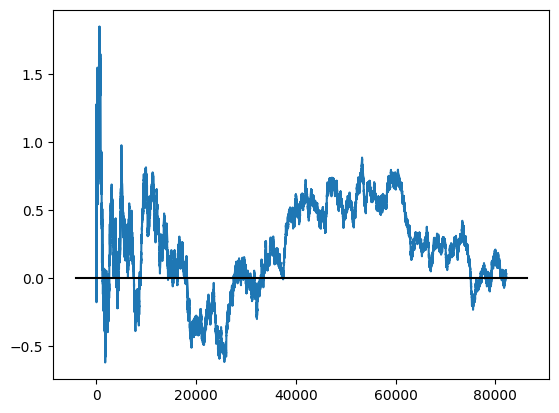

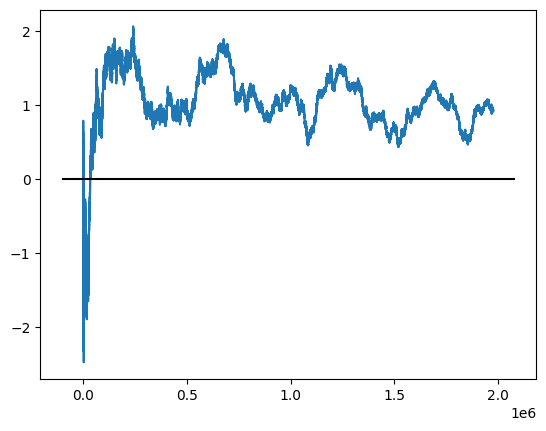

In [33]:
import numpy as np
import scipy

SPANLENGTH = 60 #specify span in seconds
sliding_window_length = 1 #event duartion ends up being span length times this

allyears_heldout_event_stats = []

for year in range(1999, 2023):
  print("Analysis for year", year)
  (all_query_stats_chisqtoz, all_heldout_stats_chisqtoz, span_start_timestamps,
   query_deviceflags, heldout_deviceflags) = load_data(year, SPANLENGTH)

  from matplotlib import pyplot as plt

  print(scipy.stats.normaltest(all_query_stats_chisqtoz))
  print(scipy.stats.normaltest(all_heldout_stats_chisqtoz))

  event_start_end_idxs = define_events(query_stats=all_query_stats_chisqtoz,
                                       sliding_window_length=sliding_window_length,
                                       min_score=1.0)
  print(len(event_start_end_idxs))
  heldout_event_stats = np.array([np.sum(all_heldout_stats_chisqtoz[x[0]:x[1]])/np.sqrt(sliding_window_length)
                         for x in event_start_end_idxs])
  plt.plot(np.arange(len(heldout_event_stats))+1, np.cumsum(heldout_event_stats)/np.sqrt(np.arange(len(heldout_event_stats))+1))
  plt.plot(plt.xlim(), [0,0], color="black")
  plt.show()

  allyears_heldout_event_stats.extend(heldout_event_stats)
  plt.plot(np.arange(len(allyears_heldout_event_stats))+1, np.cumsum(allyears_heldout_event_stats)/np.sqrt(np.arange(len(allyears_heldout_event_stats))+1))
  plt.plot(plt.xlim(), [0,0], color="black")
  plt.show()

#  plt.hist(all_query_stats_chisqtoz, bins=100, alpha=0.5, density=True)
#  plt.hist(all_heldout_stats_chisqtoz, bins=100, alpha=0.5, density=True)
#  plt.show()

  #sort the query indices in descending order
#  sorted_query_indices = np.argsort(-all_query_stats_chisqtoz)
#  resorted_heldout_stats_chisqtoz = all_heldout_stats_chisqtoz[sorted_query_indices]

#  cumsum_resorted_heldout_stats_chisqtoz = (np.cumsum(resorted_heldout_stats_chisqtoz)/
#                                            np.sqrt(np.arange(len(resorted_heldout_stats_chisqtoz)) + 1))

#  plt.plot(all_query_stats_chisqtoz[sorted_query_indices[::100]],
#          cumsum_resorted_heldout_stats_chisqtoz[::100])
#  plt.show()